In [245]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as custom_tfms
import seaborn as sns
import transformation_funcs as tfs

torch.cuda.set_device(2) 


def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df

In [246]:
X = np.load('./data/big_numpy_datasets/WFDB_CPSC2018.npy', mmap_mode='c')
label_df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])

y = snomedConvert(label_df)


In [247]:
# winner did not use multi-label for testing
ml_index = y.index[y.sum(axis=1)>1]
one_label_idx = y.index[y.sum(axis=1)<=1]

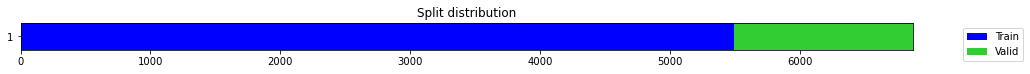

((#5502) [0,1,2,3,4,5,6,7,8,9...],
 (#1375) [5502,5503,5504,5505,5506,5507,5508,5509,5510,5511...])

In [248]:
splits = get_splits(y.to_numpy(), valid_size=.2,test_size=0, stratify=True, random_state=23, shuffle=False)
splits

In [249]:
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])
y = snomedConvert(df)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


### We Need DLs
- dls -> all data with labels

- udls -> all data without labels

In [287]:
tfms = [None,TSMultiLabelClassification()]
batch_tfms = [
              tfs.Normalize(),
              tfs.RandomShift(0.1),
              tfs.MulNoise(6),
              tfs.Scale(scale_factor=0.3)
             ]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0) 
udsets = TSDatasets(X.astype(float), tfms=tfms, splits=splits)
udls = TSDataLoaders.from_dsets(udsets.train,udsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0) 

#### Training baseline

epoch,train_loss,valid_loss,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.311276,0.265991,0.823921,0.269208,0.992204,0.404487,00:06
1,0.240820,0.227406,0.794673,0.403265,0.985687,0.533481,00:05
2,0.199758,0.312527,0.619424,0.410704,0.965941,0.493354,00:05
3,0.178772,0.258504,0.712028,0.479327,0.973758,0.572470,00:06
4,0.171077,0.210837,0.786372,0.546956,0.979799,0.644804,00:05
5,0.169280,0.209705,0.771990,0.582035,0.976497,0.663276,00:05
6,0.165306,0.226362,0.714756,0.593573,0.967686,0.647973,00:06
7,0.161685,0.169196,0.845381,0.655329,0.983655,0.737490,00:05
8,0.156660,0.171733,0.808812,0.664517,0.978599,0.729133,00:06
9,0.154639,0.160405,0.843904,0.683311,0.982743,0.754541,00:05


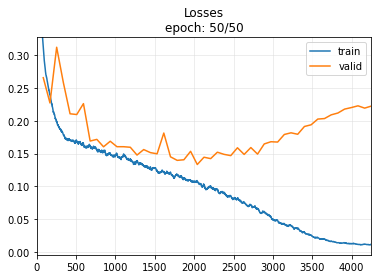

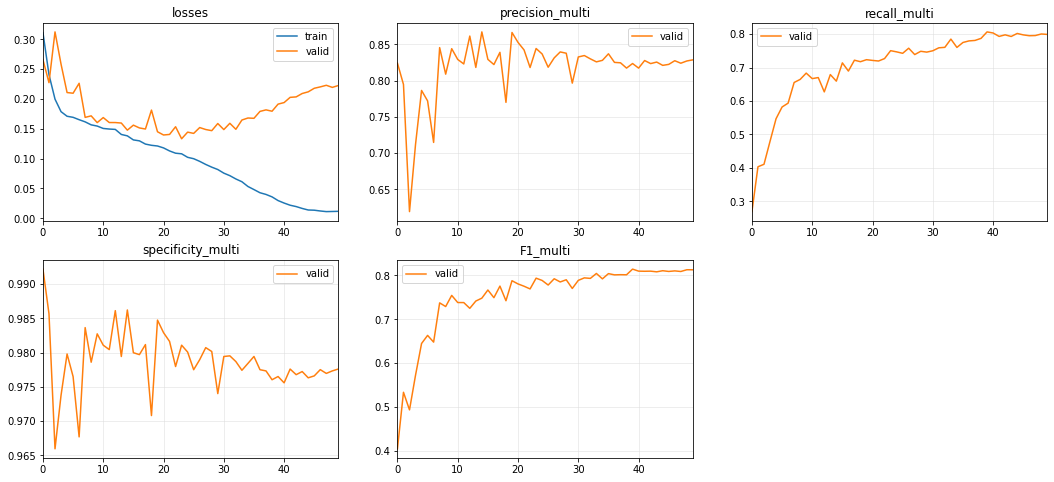

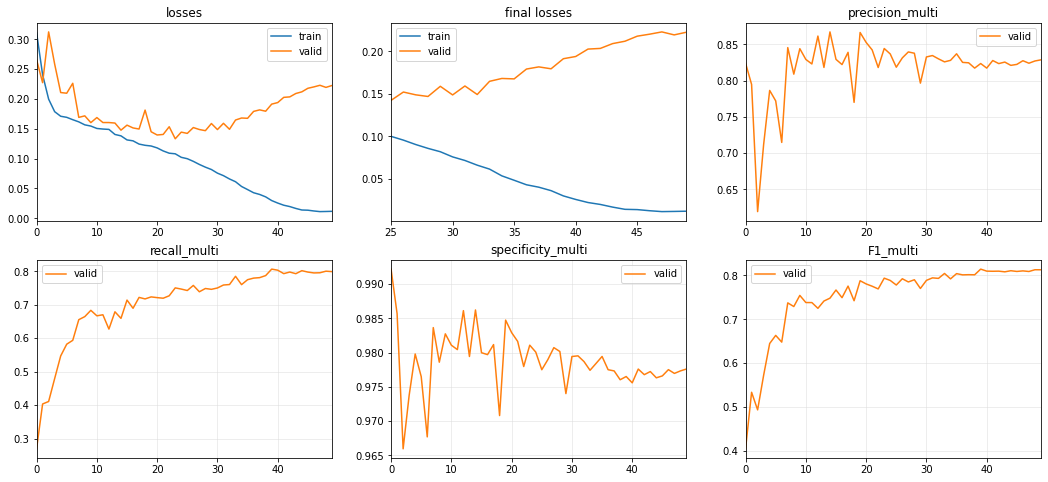

In [382]:

# reorganize y dataframe using dl's label/vocab mapping and count pos_weights

metrics = [precision_multi, recall_multi, specificity_multi, F1_multi] 
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,)
learn = Learner(dls, model, metrics=metrics, loss_func=nn.BCEWithLogitsLoss(),cbs=ShowGraph())
learn.fit_one_cycle(50, lr_max=2e-2)
learn.recorder.plot_metrics()

PRE-TRAINING

epoch,train_loss,valid_loss,time
0,0.046642,0.014581,00:05
1,0.018988,0.007350,00:05
2,0.009581,0.004465,00:05
3,0.006266,0.004479,00:05
4,0.004924,0.003291,00:05
5,0.004345,0.004430,00:05
6,0.004141,0.004516,00:05
7,0.003845,0.004398,00:05
8,0.003290,0.002790,00:05
9,0.003046,0.002777,00:05


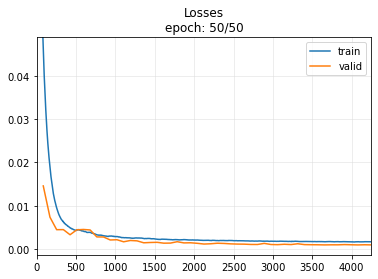


epochs: 50 best epoch:  47  val_loss: 0.000942 - pretrained weights_path='data/MVP/ts_learner.pth'



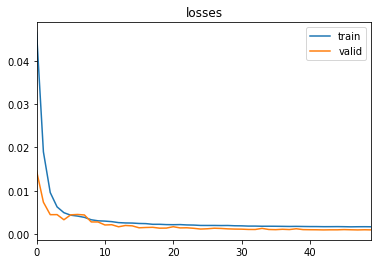

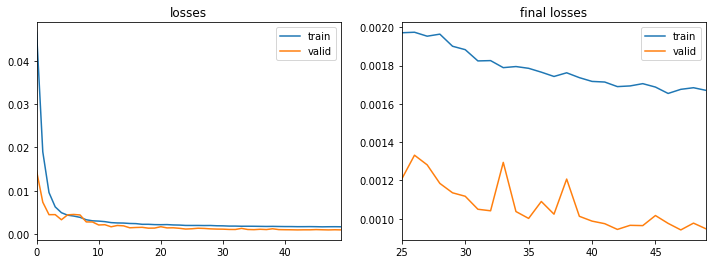

In [383]:

# reorganize y dataframe using dl's label/vocab mapping and count pos_weights

metrics =[precision_multi, recall_multi, specificity_multi, F1_multi] 
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,)
learn = Learner(udls, model, metrics=metrics, loss_func=nn.BCEWithLogitsLoss(),cbs=[ShowGraph(), MVP(target_dir='models/MVP', fname="reg_learner")])
learn = ts_learner(udls, InceptionTimePlus, cbs=[ShowGraph(), MVP(target_dir='./data/MVP', fname="ts_learner")])
learn.fit_one_cycle(50, lr_max=1e-2)
learn.recorder.plot_metrics()

Fine tuning

In [380]:
learn = ts_learner(dls, InceptionTimePlus, pretrained=True, weights_path="data/MVP/reg_learner.pth", metrics=accuracy)
for p in learn.model.parameters():
    p.requires_grad=False
print(f'{"trainable params once manually frozen":40}: {count_parameters(learn.model):8}')
learn.freeze()
print(f'{"trainable params after learn.freeze()":40}: {count_parameters(learn.model):8}')
learn.unfreeze()
print(f'{"trainable params learn.unfreeze()":40}: {count_parameters(learn.model):8}')

weights from data/MVP/reg_learner.pth successfully transferred!

trainable params once manually frozen   :        0
trainable params after learn.freeze()   :  7778129
trainable params learn.unfreeze()       :  8233041


check unmatched_layers: ['head.0.1.weight', 'head.0.1.bias']


epoch,train_loss,valid_loss,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.674494,0.457244,0.420924,0.391701,0.926465,0.405340,00:05
1,0.435628,0.500853,0.701340,0.302740,0.982555,0.422311,00:05
2,0.374838,0.342745,0.624871,0.342750,0.971823,0.441665,00:05
3,0.294969,0.276956,0.630448,0.432659,0.965490,0.512541,00:05
4,0.244170,0.236561,0.705029,0.460282,0.973838,0.556579,00:05
5,0.224834,0.223243,0.771555,0.492760,0.980172,0.601136,00:05
6,0.217507,0.218797,0.716484,0.555296,0.970170,0.624973,00:05
7,0.208536,0.220774,0.758175,0.529435,0.976773,0.622478,00:05
8,0.199087,0.247575,0.781635,0.505607,0.980716,0.613676,00:05
9,0.210826,0.212402,0.779657,0.516410,0.980258,0.620456,00:05


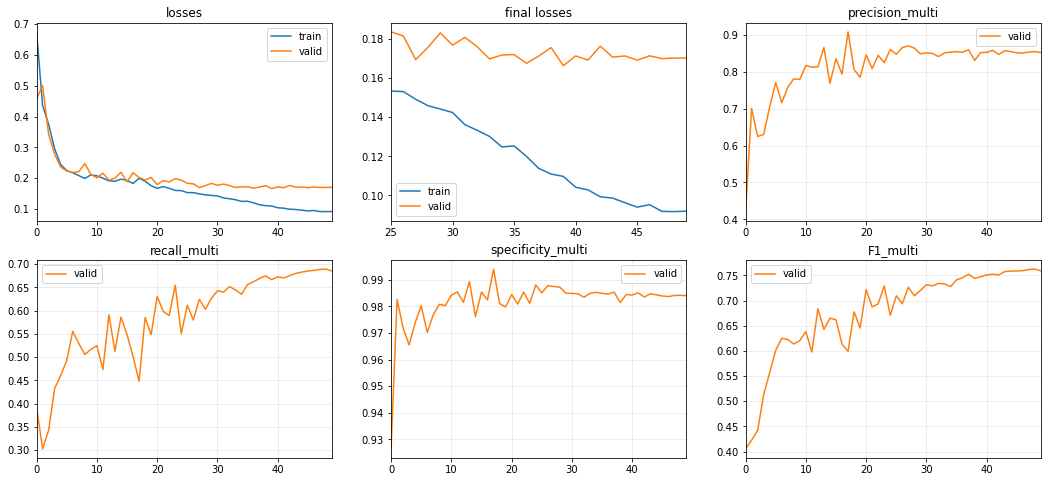

In [385]:

# reorganize y dataframe using dl's label/vocab mapping and count pos_weights

metrics =[ precision_multi, recall_multi, specificity_multi, F1_multi] 
learn = ts_learner(dls, InceptionTimePlus, c_out=1,pretrained=True,exclude_head=False, loss_func=nn.BCEWithLogitsLoss(),weights_path="models/MVP/reg_learner.pth", metrics=metrics
            )
learn.fit_one_cycle(50, lr_max=2e-2)
learn.recorder.plot_metrics()

In [ ]:
# self-supervised: fine-tuning with 100% labels
n_epochs = 50
freeze_epochs = 10
n_tests = 10
_result = []
for i in range(n_tests):
    clear_output()
    if i > 0: print(f'{i}/{n_tests} accuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f}')
    else: print(f'{i}/{n_tests}')
    learn = ts_learner(dls, InceptionTimePlus, pretrained=True, weights_path=f'data/MVP/{"pre-trained"}_200.pth', metrics=accuracy)
    learn.fine_tune(n_epochs, base_lr=2e-2, freeze_epochs=freeze_epochs)
    _result.append(learn.recorder.values[-1][-1])
learn.plot_metrics()
print(f'\naccuracy: {np.mean(_result):.3f} +/- {np.std(_result):.3f} in {n_tests} tests')